In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

In [2]:
# 0 : pas de frande liée à une transaction
# 1 :  frande liée à une transaction

# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [3]:
import numpy as np
import pandas as pd
import datatable as dt
import gc
from joblib import load, dump
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import streamlit as st
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from joblib import load
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Préparer un modèle de taille plus légère

In [4]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

train_df = dt.fread('train_df.csv', sep=',').to_pandas()
train_df = train_df.sample(int(len(train_df) * 0.1))
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
train_x = train_df[feats]
train_y = train_df['TARGET']
clf.fit(train_x, train_y)

/home/ying/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [5]:
dump(clf,'LightGBMC_app.joblib')

['LightGBMC_app.joblib']

In [6]:
clf2 = LGBMClassifier()
clf2.fit(train_x, train_y)
dump(clf2,'LightGBMC_app_sans_param.joblib')

['LightGBMC_app_sans_param.joblib']

In [7]:
threshold = 0.1685

test_df= pd.read_csv("test_df.csv", sep=',')
submission_kernel02= pd.read_csv("submission_kernel02.csv", sep=',')
print("test_df shape: {}, submission_kenel02 shape : {})".format(test_df.shape, submission_kernel02.shape))
test_df.TARGET.isna().mean()

test_df shape: (48744, 798), submission_kenel02 shape : (48744, 2))


1.0

In [8]:
test_df = test_df.drop(columns=["TARGET"])
sub_test_df = submission_kernel02.merge(test_df, how='left', on='SK_ID_CURR')
sub_test_df.rename(columns={'TARGET': 'TARGET_proba'}, inplace=True)
sub_test_df['TARGET'] = [1 if x >= threshold else 0 for x in sub_test_df['TARGET_proba']]

app_df = sub_test_df.sample(int(len(sub_test_df) * 0.1))

In [9]:
most_imputer = SimpleImputer(strategy='most_frequent')
app_df =pd.DataFrame(most_imputer.fit_transform(app_df), 
                              columns=app_df.columns)
feats = [f for f in app_df.columns if f not in ['TARGET','TARGET_proba','SK_ID_CURR','index','SK_ID_BUREAU','SK_ID_PREV']]
X= app_df[feats]
y = app_df["TARGET"]


fi_df =pd.read_csv("feature_importance_df.csv", sep=',')
cols = fi_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_fi = fi_df.loc[fi_df.feature.isin(cols)]

HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', sep=',', encoding = 'iso8859_1')
row_description = HomeCredit_columns_description.loc[HomeCredit_columns_description.Row.isin(best_fi.feature), ["Row", "Description"]]
feature_descriptions= dict(zip(row_description.Row,row_description.Description))


In [10]:

list_features = best_fi.sort_values(by="importance" , ascending=False)[:100]["feature"].unique().tolist()

2022-11-16 16:07:03.608 WARNING matplotlib.font_manager: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-11-16 16:07:03.613 WARNING matplotlib.font_manager: findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
2022-11-16 16:07:03.656 WARNING matplotlib.font_manager: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-11-16 16:07:03.657 WARNING matplotlib.font_manager: findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
2022-11-16 16:07:03.679 WARNING matplotlib.font_manager: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-11-16 16:07:03.680 WARNING matplotlib.font_manager: findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation 

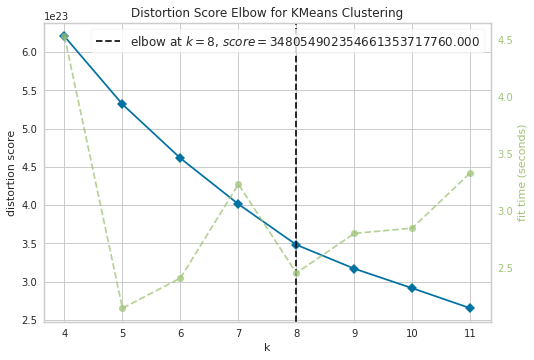

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model_kmeans = KMeans()
visualizer = KElbowVisualizer(model_kmeans, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()   

In [12]:
Kmean = KMeans(n_clusters= visualizer.elbow_value_)
Kmean.fit(X)

KMeans()

In [ ]:
app_df["kmeans_label"] = Kmean.labels_
app_df.SK_ID_CURR=app_df.SK_ID_CURR.astype(int)
app_df.TARGET = app_df.TARGET.astype(int)
app_df.to_csv("app_streamlit_df.csv",index=False)

In [ ]:
feats = [f for f in app_df.columns if f not in ['TARGET','TARGET_proba','kmeans_label','SK_ID_CURR','index','SK_ID_BUREAU','SK_ID_PREV']]
X= app_df[feats]
y = app_df["TARGET"]